# Hard magnet tutorial – with AI-based property predictions

## Introduction

- This notebook demonstrates how to use the `mammos-ai` package to predict hard magnet properties using pre-trained machine learning models.
- This is the same workflow as the [hard magnet tutorial](./hard-magnet-tutorial.ipynb) but uses AI models to predict hysteresis properties instead of micromagnetic simulations.


Requirements:
- Software: `mammos`
- Basic understanding of [hard magnet tutorial](./hard-magnet-tutorial.ipynb)

In [1]:
%config InlineBackend.figure_format = "retina"


from pprint import pprint

import mammos_ai
import mammos_analysis
import mammos_dft
import mammos_entity as me
import mammos_spindynamics
import mammos_units as u
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Allow convenient conversions between A/m and T
u.set_enabled_equivalencies(u.magnetic_flux_field());

## Load data from DFT and spindynamics databases

In [3]:
material = "Co2Fe2H4"

results_dft = mammos_dft.db.get_micromagnetic_properties(material)
results_spindynamics = mammos_spindynamics.db.get_spontaneous_magnetization(material)

## Calculate micromagnetic intrinsic properties using Kuz’min formula

In [4]:
results_kuzmin = mammos_analysis.kuzmin_properties(
    T=results_spindynamics.T,
    Ms=results_spindynamics.Ms,
    K1_0=results_dft.Ku_0,
)

The Tc is

In [5]:
results_kuzmin.Tc

Entity(ontology_label='CurieTemperature', value=1061.566442835135, unit='K')

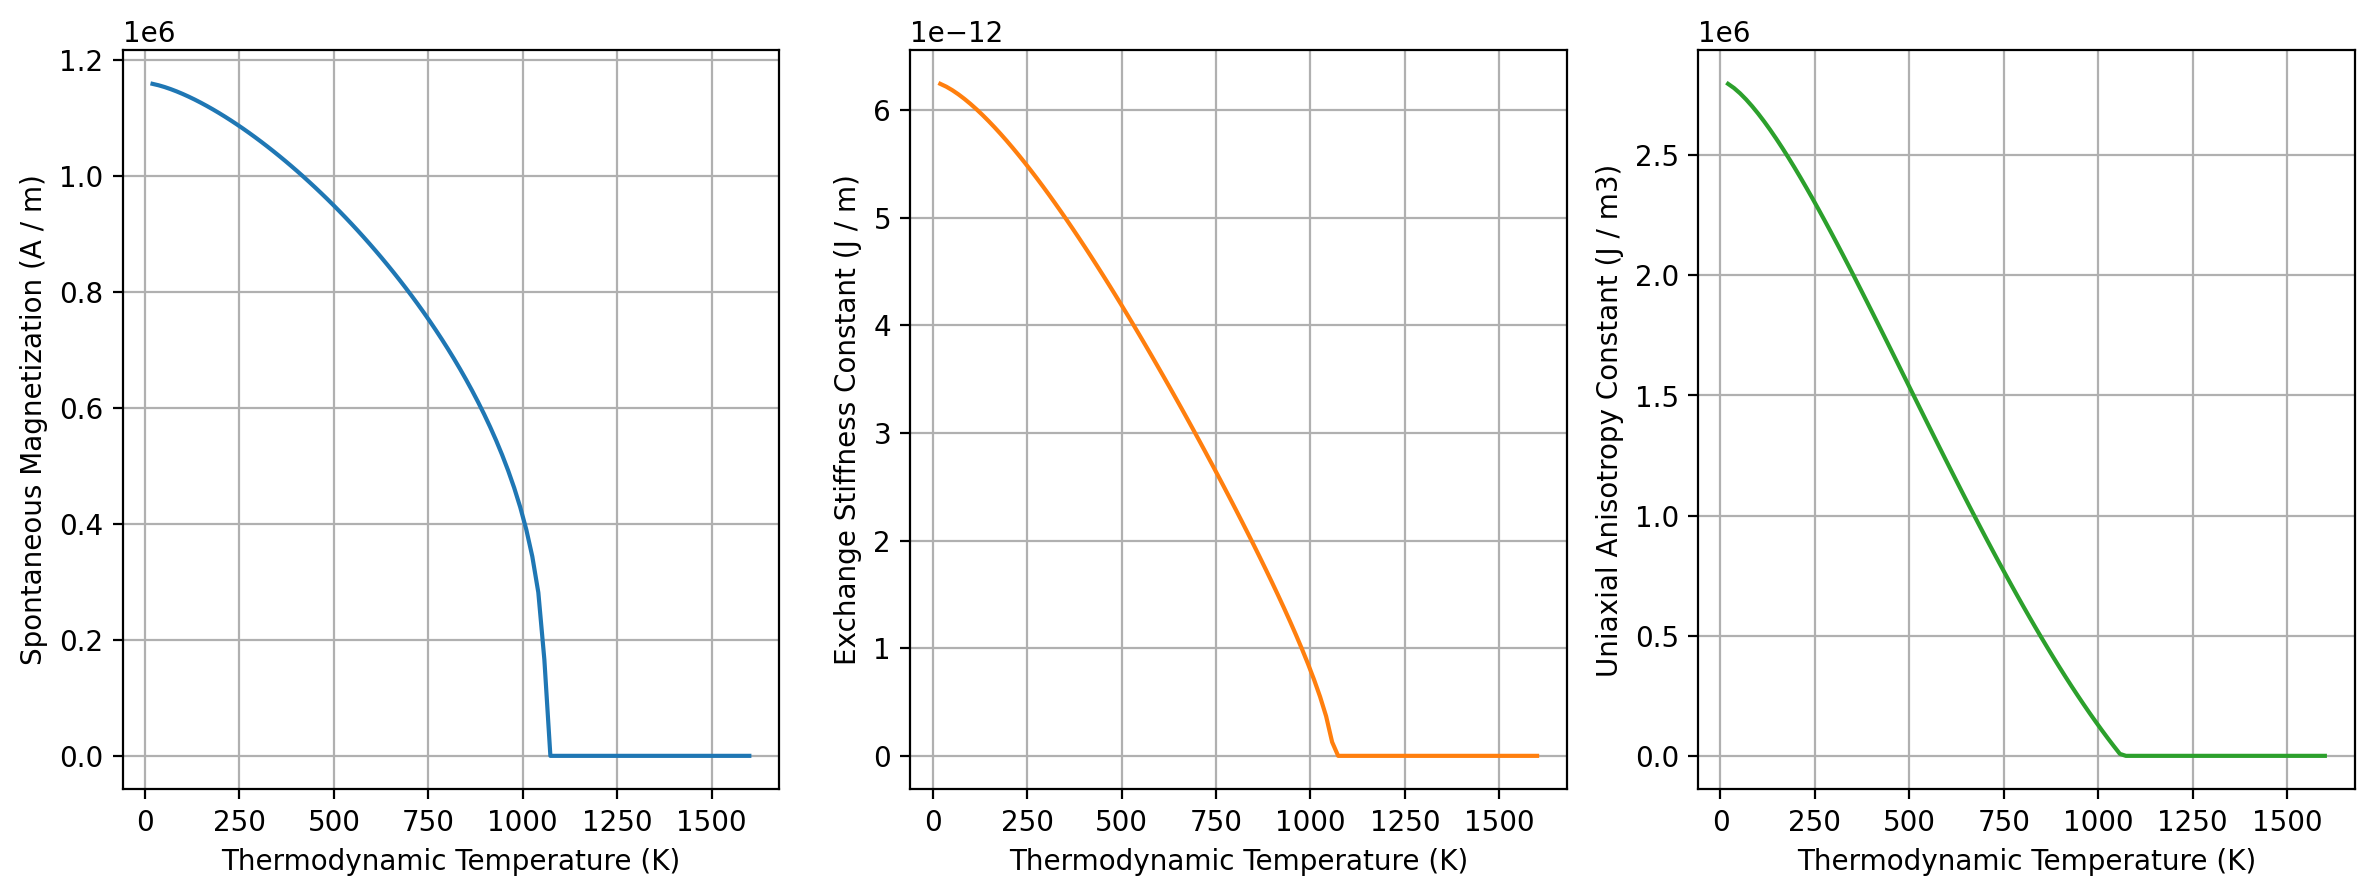

In [6]:
results_kuzmin.plot();

## AI-based prediction of extrinsic properties
Rather than running micromagnetic simulations to compute hysteresis loops and derive extrinsic properties such as coercive field Hc and maximum energy product BHmax, we use pre-trained machine learning models from the `mammos-ai` package.

Details about the model and its training data can be found in the [training repository](https://github.com/MaMMoS-project/ML-models/tree/main/beyond-stoner-wohlfarth/single-grain-easy-axis-model).

This approach allows for rapid predictions of hysteresis properties based on the intrinsic micromagnetic parameters computed earlier.

The model was trained using a 50 × 50 × 50 nm cubic grain with uniaxial anisotropy, where both the anisotropy axis and the applied magnetic field were oriented along a cube edge.

In [7]:
T = np.linspace(0, 1.1 * results_kuzmin.Tc.q, 20)

results_ai = mammos_ai.Hc_Mr_BHmax_from_Ms_A_K(
    Ms=results_kuzmin.Ms(T),
    A=results_kuzmin.A(T),
    K1=results_kuzmin.K1(T),
)

This has returned an `ExtrinsicProperties` object containing the predicted hysteresis properties. This is the same object type as returned by running micromagnetic simulations and them processing them with `mammos_analysis.hysteresis.extrinsic_properties` in the hard magnet tutorial.

In [8]:
results_ai

ExtrinsicProperties(Hc=Entity(ontology_label='CoercivityHcExternal', value=array([2942256.2  , 2857558.5  , 2740996.8  , 2543269.5  , 2428668.5  ,
       2208944.   , 2115859.   , 1819307.6  , 1808106.2  , 1698485.6  ,
       1829058.5  , 1429938.1  , 1091347.4  ,  903446.3  , 1116855.1  ,
       1057900.2  ,  966576.75 ,   17457.65 ,   17204.068,   17204.068],
      dtype=float32), unit='A / m'), Mr=Entity(ontology_label='Remanence', value=array([1142329.1  , 1137940.8  , 1132234.9  , 1115691.5  , 1108781.   ,
       1087777.1  , 1069930.6  , 1039830.7  ,  997795.75 ,  947130.56 ,
        841426.94 ,  782085.25 ,  755020.2  ,  736731.56 ,  618404.6  ,
        582873.56 ,  390627.44 ,   61490.266,   57923.465,   57923.465],
      dtype=float32), unit='A / m'), BHmax=Entity(ontology_label='MaximumEnergyProduct', value=array([409878.44, 406728.28, 402647.75, 390956.53, 386122.5 , 371605.25,
       359498.5 , 339515.28, 312623.38, 281647.78, 222328.2 , 192068.8 ,
       178941.03, 170193.

At higher temperatures, the predictions become less accurate. This is because some samples are no longer classified as hard magnets based on their intrinsic properties, so the model switches to a non-hard-magnet predictor, which is less accurate. Even more than that, the model may be extrapolating beyond its training data, leading to unphysical results. We can check the metadata of the model to see the range of input parameters it was trained on. For each of the model inputs, we get minimum and the maximum value of the data in the training set of the AI model:

In [9]:
pprint(mammos_ai.Hc_Mr_BHmax_from_Ms_A_K_metadata()["training_data_range"])

{'A': (Entity(ontology_label='ExchangeStiffnessConstant', value=1e-13, unit='J / m'),
       Entity(ontology_label='ExchangeStiffnessConstant', value=1e-11, unit='J / m')),
 'K': (Entity(ontology_label='UniaxialAnisotropyConstant', value=10000.0, unit='J / m3'),
       Entity(ontology_label='UniaxialAnisotropyConstant', value=10000000.0, unit='J / m3')),
 'Ms': (Entity(ontology_label='SpontaneousMagnetization', value=79580.0, unit='A / m'),
        Entity(ontology_label='SpontaneousMagnetization', value=3980000.0, unit='A / m'))}


We can visualize the predicted extrinsic properties as a function of temperature;
starting with the remanence Mr:

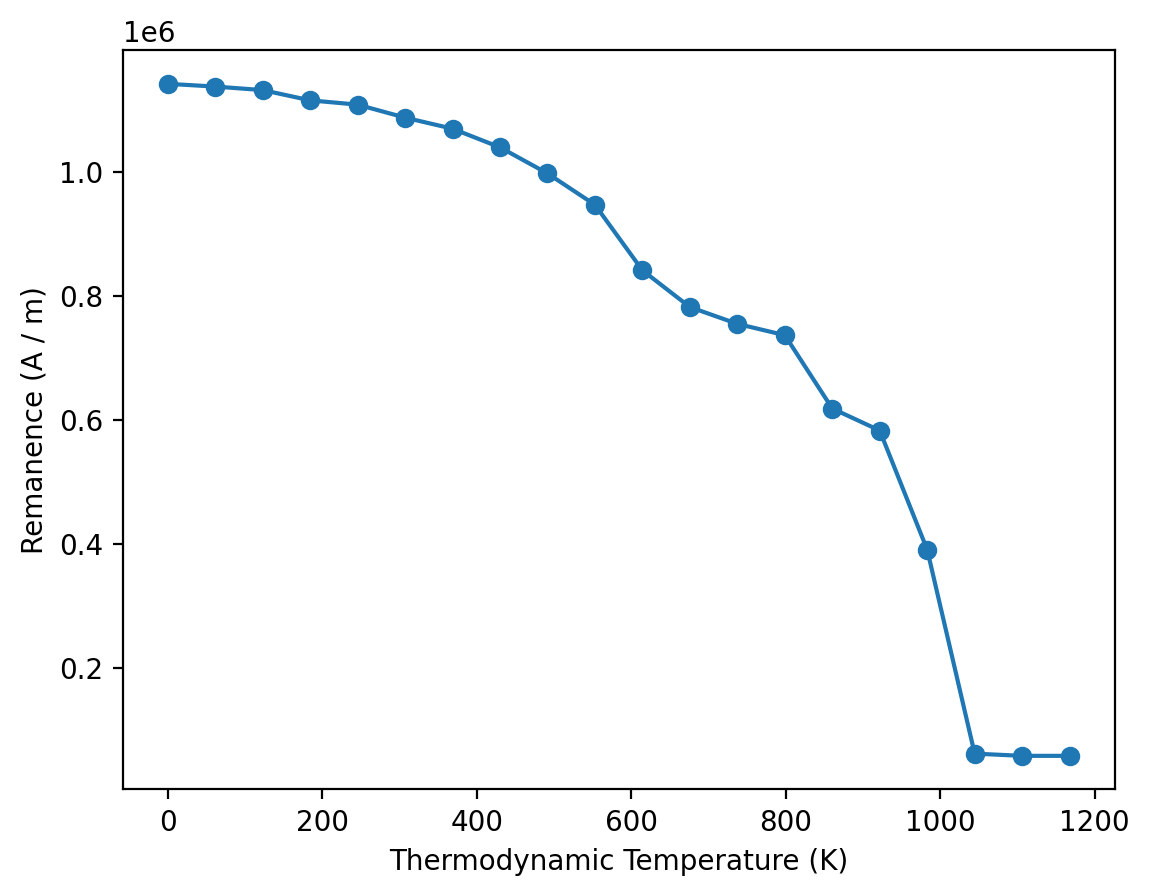

In [10]:
plt.plot(T, results_ai.Mr.value, linestyle="-", marker="o")
plt.xlabel(me.T().axis_label)
plt.ylabel(me.Mr().axis_label);

We known that the remanence Mr for hard magnets is approximately the saturation magnetization Ms so we expect a similar temperature dependence. When we plot them together we can see that this is indeed the case. However, the AI model is not perfect, as Ms should be a hard upper limit for Mr and we see some predicted Mr values slightly exceeding Ms. 

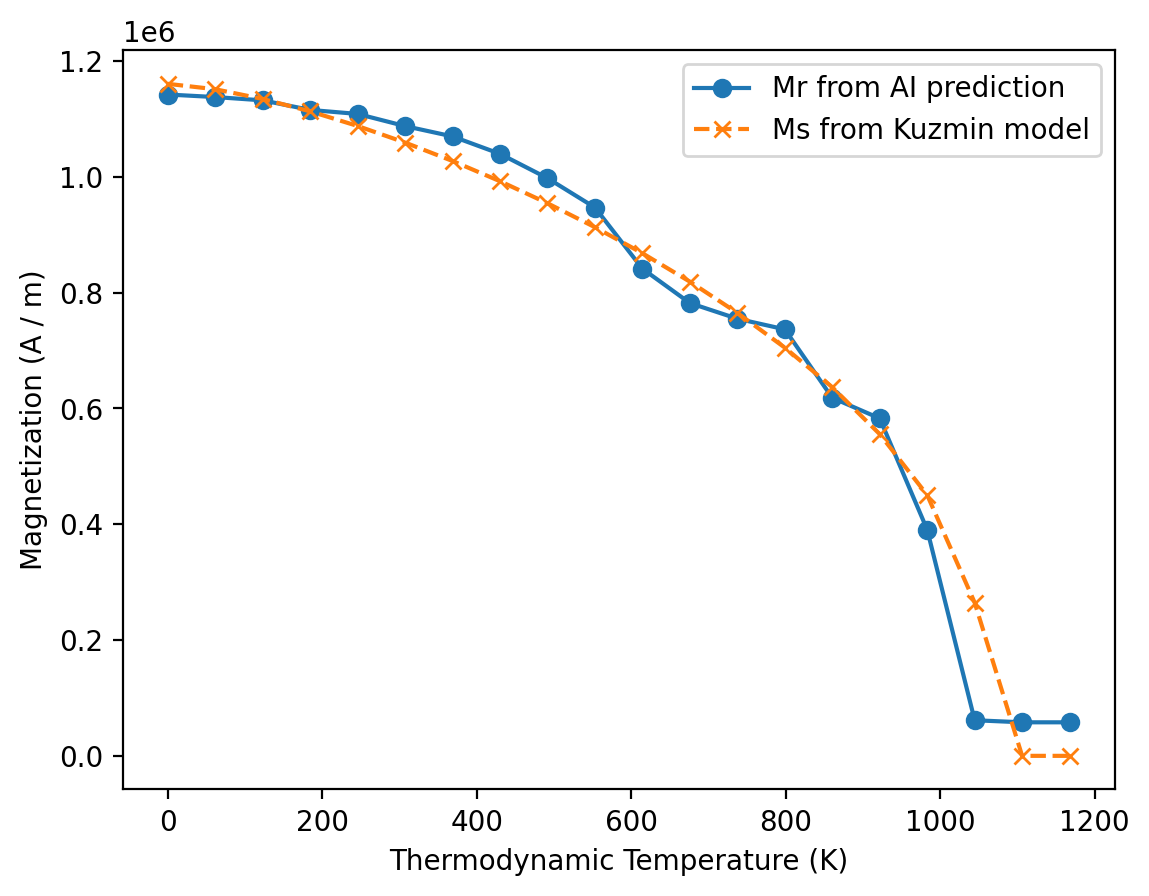

In [11]:
plt.plot(T, results_ai.Mr.value, linestyle="-", marker="o", label="Mr from AI prediction")
plt.plot(T, results_kuzmin.Ms(T).value, linestyle="--", marker="x", label="Ms from Kuzmin model")
plt.xlabel(me.T().axis_label)
plt.ylabel(me.M().axis_label)
plt.legend();

We can also see how the coercive field changes with temperature:

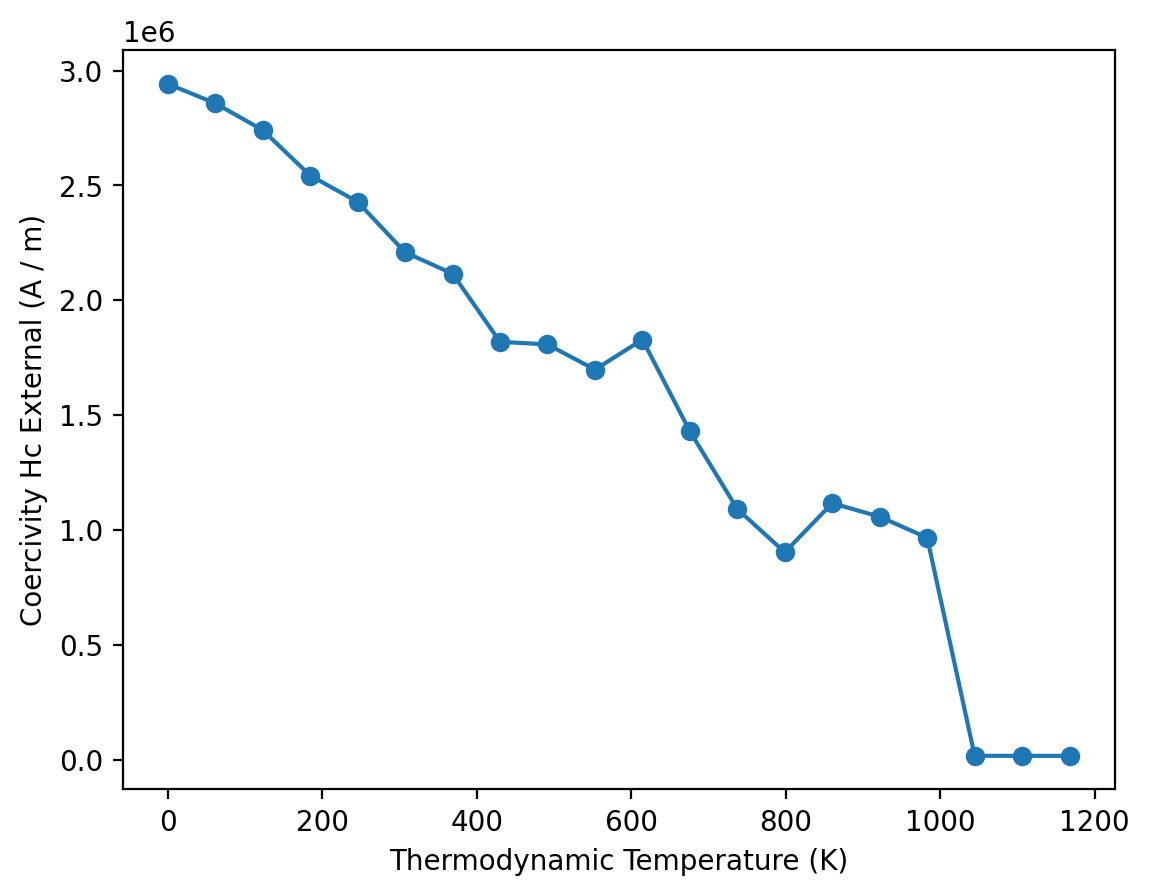

In [12]:
plt.plot(T, results_ai.Hc.value, linestyle="-", marker="o")
plt.xlabel(me.T().axis_label)
plt.ylabel(me.Hc().axis_label);

Finally we look at the maximum energy product BHmax. This shows a clear error at higher temperatures, where the values jump significantly. The input to the function at these high temperature points is outside the training data range, so the model cannot be expected to return meaningful results.

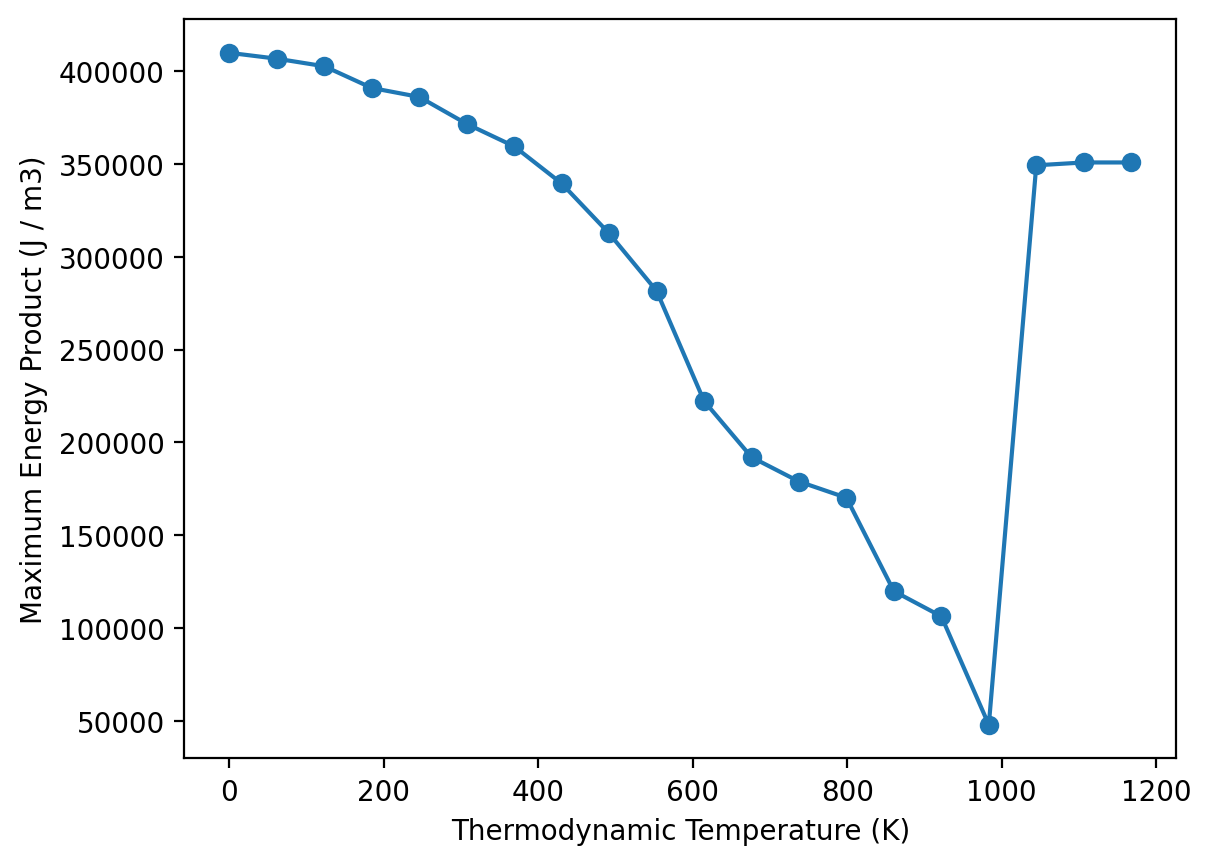

In [13]:
plt.plot(T, results_ai.BHmax.value, linestyle="-", marker="o")
plt.xlabel(me.T().axis_label)
plt.ylabel(me.BHmax().axis_label);

Internally, the model checks if the sample is a hard magnet based on the intrinsic properties. If it is, it uses a hard-magnet predictor. If it is not, it switches to a non-hard-magnet predictor. We can directly check which samples are classified as hard magnets:

In [14]:
mammos_ai.is_hard_magnet_from_Ms_A_K(
    Ms=results_kuzmin.Ms(T),
    A=results_kuzmin.A(T),
    K1=results_kuzmin.K1(T),
)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False])

In this notebook, we have shown how the `mammos-ai` package can serve as a fast alternative to full micromagnetic simulations for predicting the hysteresis properties of hard magnets. By using intrinsic micromagnetic parameters as inputs, the model provides rapid estimates that avoid the hours-long runtime of traditional simulations. However, this speed comes with reduced accuracy, particularly when extrapolating beyond the range of the training data. Users should therefore take care when interpreting results.